In [133]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Neural Net libraries. 
# I installed the live version of lasagne, theano, and nolearn directly from git. Follow this instructions here:
# https://github.com/dnouri/nolearn
from lasagne import layers
from lasagne import nonlinearities
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

In [3]:
data = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/train.csv")
test = pd.read_csv("/Users/cjllop/Code/MIDS/MLearning/Final/Data/test.csv")


In [4]:
# Big Picture of Data
print "Train Data:"
print data.shape
print data.columns.values
print "Test Data:"
print test.shape
print test.columns.values


Train Data:
(878049, 9)
['Dates' 'Category' 'Descript' 'DayOfWeek' 'PdDistrict' 'Resolution'
 'Address' 'X' 'Y']
Test Data:
(884262, 7)
['Id' 'Dates' 'DayOfWeek' 'PdDistrict' 'Address' 'X' 'Y']


In [124]:
# Add a column counting days since the min date in the dataset
def add_date_diff(df):
    datetime_vector = pd.to_datetime(df['Dates'])
    date_vector = datetime_vector.dt.date
    date_diff_vector = (date_vector - date_vector.min()) / np.timedelta64(1, 'D')
    df['DateDiff'] = date_diff_vector
    df['Year'] = datetime_vector.dt.year
    df['Month'] = datetime_vector.dt.month
    df['Day'] = datetime_vector.dt.day
    df['Hour'] = datetime_vector.dt.hour
    df['DayOfYear'] = datetime_vector.dt.dayofyear

add_date_diff(data)
add_date_diff(test)
#print data.DateDiff.describe()
#print test.DateDiff.describe()


In [126]:
# Lasagne works off of Theano instead of Numpy
#print data.Category
train_data = np.array(data[['X','Y','Year','Month','Day','Hour','DayOfYear']].values)

panda_labels = pd.Categorical(data.Category).labels
train_labels = np.array(panda_labels).astype(np.int32)
print train_labels

[37 21 21 ..., 16 35 12]


In [6]:
# Create random dev sample so we can see how that accuracy compares to our Kaggle results
# np.random.seed(100)

# Pick 10% of rows for dev
# rows = np.random.choice(data.index, size = len(data) / 10, replace = False)

# dev = data.ix[rows]
# train = data.drop(rows)

# print train.shape
# print dev.shape
# print test.shape


(790245, 10)
(87804, 10)
(884262, 8)


In [146]:
# Simple net... for some reason this is currently just picking the most common class for everything
net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 7),  # 3 input pixels per batch
    hidden_num_units=10,  # number of units in hidden layer
    output_nonlinearity=nonlinearities.softmax,
    output_num_units=39,  # 39 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=10,  # we want to train this many epochs
    verbose=1,
    )

net1.fit(train_data, train_labels)

# Neural Network with 509 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input        7
  1  hidden      10
  2  output      39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1     233.39494       2.70657     86.23266      0.19904  1.86s
      2       2.64475       2.70492      0.97776      0.19904  1.87s
      3       2.64386       2.70447      0.97759      0.19904  1.85s
      4       2.64356       2.70428      0.97755      0.19904  1.94s
      5       2.64343       2.70418      0.97753      0.19904  1.93s
      6       2.64335       2.70412      0.97753      0.19904  1.90s
      7       2.64330       2.70408      0.97752      0.19904  1.99s
      8       2.64327       2.70406      0.97752      0.19904  2.22s
      9       2.64324       2.70404      0.97752      0.19904  2.06s
     10       2.64323       2.70402      0.97752      0.19904  2.02s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c727450>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c7273d0>,
     custom_score=None, hidden_num_units=10, input_shape=(None, 7),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=10, more_params={},
     objective=<function objective at 0x10c72a938>,
     objective_loss_function=<function categorical_crossentropy at 0x10c645a28>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x11a916560>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x11a9165f0>],
     output_nonlinearity=<function softmax at 0x10c4fa140>,
     output_num_units=39, regression=False,
     train_split=<nolearn.lasagne.base.TrainSplit object at

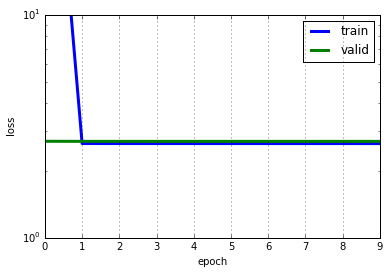

In [147]:
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-0, 1e1)
plt.yscale("log")
plt.show()

# Looks pretty bad!

In [153]:
train_pred = net1.predict(train_data)
print(classification_report(train_labels, train_pred))
print 'The accuracy is:', accuracy_score(train_labels, train_pred)



             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1513
          1       0.00      0.00      0.00     76876
          2       0.00      0.00      0.00       406
          3       0.00      0.00      0.00       289
          4       0.00      0.00      0.00     36755
          5       0.00      0.00      0.00      4320
          6       0.00      0.00      0.00      2268
          7       0.00      0.00      0.00     53971
          8       0.00      0.00      0.00      4280
          9       0.00      0.00      0.00      1166
         10       0.00      0.00      0.00       256
         11       0.00      0.00      0.00       491
         12       0.00      0.00      0.00     10609
         13       0.00      0.00      0.00     16679
         14       0.00      0.00      0.00       146
         15       0.00      0.00      0.00      2341
         16       0.20      1.00      0.33    174900
         17       0.00      0.00      0.00   

In [151]:
# Tried a more complicated net with layers... still doing the same thing.
net2 = NeuralNet(
    layers=[  # more layers
        ('input', layers.InputLayer),
        ('dense0', layers.DenseLayer),
        ('dropout', layers.DropoutLayer),
        ('dense1', layers.DenseLayer),
        ('output', layers.DenseLayer)
    ],
    # layer parameters:
    input_shape=(None, 7),  # 3 input pixels per batch
    dense0_num_units=10,  # number of units in hidden layer
    dropout_p=0.5,  # Not sure what this does.....
    dense1_num_units=10,  # number of units in hidden layer
    output_num_units=39,  # 39 target values
    output_nonlinearity=nonlinearities.softmax,

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.02,
    update_momentum=0.9,

    regression=False,  # flag to indicate we're not dealing with regression problem
    max_epochs=10,  # we want to train this many epochs
    verbose=1,
    )

net2.fit(train_data, train_labels)

# Neural Network with 619 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input         7
  1  dense0       10
  2  dropout      10
  3  dense1       10
  4  output       39

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       4.14217       2.70658      1.53041      0.19904  2.46s
      2       2.64476       2.70492      0.97776      0.19904  2.82s
      3       2.64386       2.70447      0.97759      0.19904  2.76s
      4       2.64356       2.70428      0.97755      0.19904  2.82s
      5       2.64343       2.70418      0.97753      0.19904  2.74s
      6       2.64335       2.70412      0.97753      0.19904  2.90s
      7       2.64330       2.70408      0.97752      0.19904  2.99s
      8       2.64327       2.70406      0.97752      0.19904  2.91s
      9       2.64324       2.70404      0.97752      0.19904  2.77s
     10       2.64323    

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10c727450>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10c7273d0>,
     custom_score=None, dense0_num_units=10, dense1_num_units=10,
     dropout_p=0.5, input_shape=(None, 7),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense0', <class 'lasagne.layers.dense.DenseLayer'>), ('dropout', <class 'lasagne.layers.noise.DropoutLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=10, more_params={},
     objective=<function objective at 0x10c72a938>,
     objective_loss_function=<function categorical_crossentropy at 0x10c645a28>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x1290f2d40>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x1290f2d88>],
     outp

____
____
____

Old code below here
____
____
____


In [11]:
#OLD - NOT USING Fit a basic RBM

#NNmodel = BernoulliRBM()
#NNmodel.fit(train_data, train_labels)


AttributeError: 'BernoulliRBM' object has no attribute 'predict'

In [7]:
# Convert to Numpy Format
# TODO: Add more features here
train_data = np.array(train[['DateDiff','X','Y']].values)
train_labels = np.array(train[['Category']].values.ravel())

dev_data = np.array(dev[['DateDiff','X','Y']].values)
dev_labels = np.array(dev[['Category']].values.ravel())

full_data = np.array(data[['DateDiff','X','Y']].values)
full_labels = np.array(data[['Category']].values.ravel())

test_data = np.array(test[['DateDiff','X','Y']].values)

# Normalize Data to Between 0-1
# a + (x-A)*(b-a)/(B-A) 
# TODO: Fix normalization to kick out "bad" x/y
train_normed = 0 + (np.abs(train_data) - np.abs(train_data).min(axis=0))*(1-0)/(np.abs(train_data).max(axis=0) - np.abs(train_data).min(axis=0)) 
dev_normed = 0 + (np.abs(dev_data) - np.abs(dev_data).min(axis=0))*(1-0)/(np.abs(dev_data).max(axis=0) - np.abs(dev_data).min(axis=0)) 

print train_normed.min(axis=0)
print train_normed.max(axis=0)

[ 0.  0.  0.]
[ 1.  1.  1.]


Code Below this point is from KNN - here to steal bits from while I work on NN.

In [9]:
# Use GridSearchCV to find a good number of neighbors.
#ks = {'n_neighbors': range(1,4)}
ks = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNNGridSearch = GridSearchCV(KNeighborsClassifier(), ks, scoring='f1_weighted')
KNNGridSearch.fit(train_data, train_labels)

# Report out on the accuracies    
print "The scores for each k value was %s " % (KNNGridSearch.grid_scores_)
print "The best k value was %s with accuracy %.4f" % (KNNGridSearch.best_params_, KNNGridSearch.best_score_)


The scores for each k value was [mean: 0.00303, std: 0.00382, params: {'n_neighbors': 1}, mean: 0.00314, std: 0.00389, params: {'n_neighbors': 2}, mean: 0.00300, std: 0.00380, params: {'n_neighbors': 3}, mean: 0.00302, std: 0.00378, params: {'n_neighbors': 4}, mean: 0.00299, std: 0.00371, params: {'n_neighbors': 5}, mean: 0.00300, std: 0.00373, params: {'n_neighbors': 6}, mean: 0.00297, std: 0.00372, params: {'n_neighbors': 7}, mean: 0.00297, std: 0.00371, params: {'n_neighbors': 8}, mean: 0.00295, std: 0.00369, params: {'n_neighbors': 9}, mean: 0.00295, std: 0.00368, params: {'n_neighbors': 10}] 
The best k value was {'n_neighbors': 2} with accuracy 0.0031


In [12]:
# Try k = 2
KNNmodel = KNeighborsClassifier(n_neighbors=1)
KNNmodel.fit(train_data, train_labels)
dev_predict = KNNmodel.predict(dev_data)
print "The KNN with DateDiff, X and Y (k=2) scores: {:.6f}".format(metrics.f1_score(dev_labels, dev_predict, average='weighted'))


# Tried a few tests (including the above). So far k=1 seems best.

The KNN with DateDiff, X and Y (k=2) scores: 0.220072


Great, now we've sorted out a naive alg to run. Let's train on all train, then predict on test

In [28]:
def create_submission(preds):
    labels = ["Id",
                "ARSON",
                "ASSAULT",
                "BAD CHECKS",
                "BRIBERY",
                "BURGLARY",
                "DISORDERLY CONDUCT",
                "DRIVING UNDER THE INFLUENCE",
                "DRUG/NARCOTIC",
                "DRUNKENNESS",
                "EMBEZZLEMENT",
                "EXTORTION",
                "FAMILY OFFENSES",
                "FORGERY/COUNTERFEITING",
                "FRAUD",
                "GAMBLING",
                "KIDNAPPING",
                "LARCENY/THEFT",
                "LIQUOR LAWS",
                "LOITERING",
                "MISSING PERSON",
                "NON-CRIMINAL",
                "OTHER OFFENSES",
                "PORNOGRAPHY/OBSCENE MAT",
                "PROSTITUTION",
                "RECOVERED VEHICLE",
                "ROBBERY",
                "RUNAWAY",
                "SECONDARY CODES",
                "SEX OFFENSES FORCIBLE",
                "SEX OFFENSES NON FORCIBLE",
                "STOLEN PROPERTY",
                "SUICIDE",
                "SUSPICIOUS OCC",
                "TREA",
                "TRESPASS",
                "VANDALISM",
                "VEHICLE THEFT",
                "WARRANTS",
                "WEAPON LAWS"
              ]
    head_str = ','.join(labels)

    num_cats = len(labels)
    
    # Make a dummy row to append to
    ids = np.arange(preds.shape[0])[np.newaxis].transpose()
    
    results = np.column_stack((ids, preds))

    # Write results to csv
    np.savetxt('sample.csv', results, fmt='%d', delimiter=',', header=head_str, comments='')

    return results

In [17]:
# Now that we've done this, let's run the KNN on the full train, apply to the test, then format.
KNNmodel = KNeighborsClassifier(n_neighbors=1)
KNNmodel.fit(full_data, full_labels)
dev_predict = KNNmodel.predict_proba(test_data).astype(int)

In [29]:
results = create_submission(dev_predict)

In [30]:
print results.shape

(884262, 40)
